In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:

sbi=pd.read_csv("NII SBI.csv")
hdfc=pd.read_csv("nii hdfc.csv")

In [3]:
def adftest(df):
  is_stationary = True
  for col in df.columns.values[1:]:
    test_result = adfuller(df[col], autolag="AIC")
    if test_result[1] > 0.05:
      is_stationary = False
    print(col, test_result[1] < 0.05)

  return is_stationary


In [4]:
adftest(sbi)

NII False
GROSS ADVANCE False
GNPA False
GNPAR False
CASA False
PCR False
WDR False
WLR False


False

In [11]:
adftest(hdfc)

NII False
GROSS ADVANCE False
GNPA False
GNPAR True
CASA True
PCR False
WDR False
WLR True


False

number of times differencing 1


[]

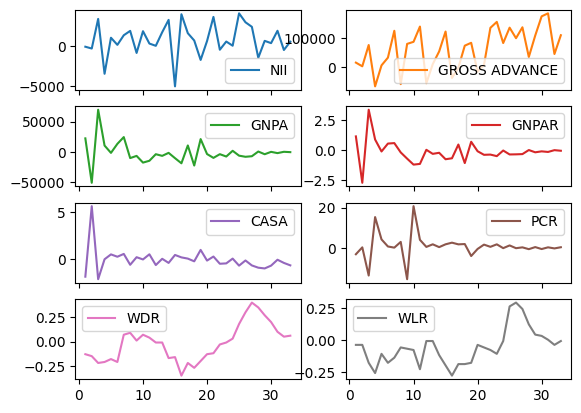

In [28]:
is_stationary = False
sbi_diff = sbi.drop("QUARTERS",axis=1).copy()
count_diff = 0

while not is_stationary:
  sbi_diff = sbi_diff.diff().dropna()
  is_stationary = adftest(pd.DataFrame(sbi_diff['NII']))
  count_diff += 1
  
  
print("number of times differencing", count_diff)
sbi_diff.plot(subplots=True, layout=(4, 2))
plt.plot()

In [30]:
# Train-Test Split (80-20 Split Example)
split_ratio = 0.8
split_index = int(len(sbi_diff['NII']) * split_ratio)

train =sbi_diff['NII'][:split_index]  # First 80% for training
test =sbi_diff['NII'][split_index:]   # Remaining 20% for testing

print(f"Train Size: {len(train)}, Test Size: {len(test)}")


Train Size: 26, Test Size: 7


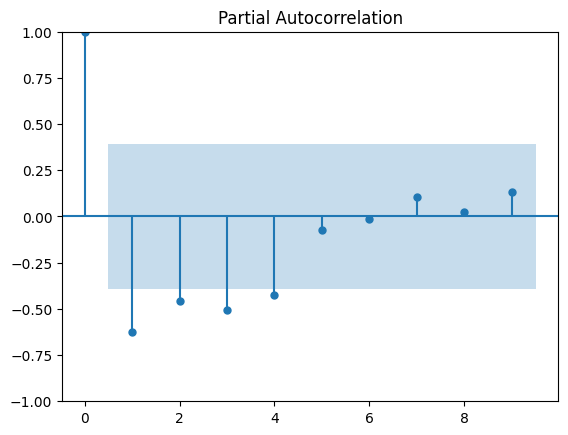

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(train.diff().dropna(), lags=9)
plt.show()


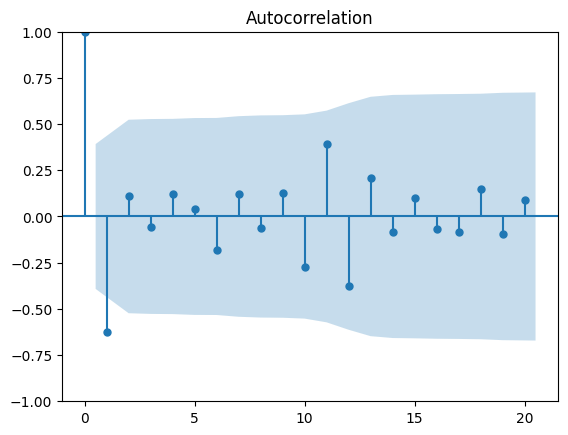

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train.diff().dropna(), lags=20)
plt.show()


C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ADMIN\AppData\Local\Programs\Py

6114195.2313739685


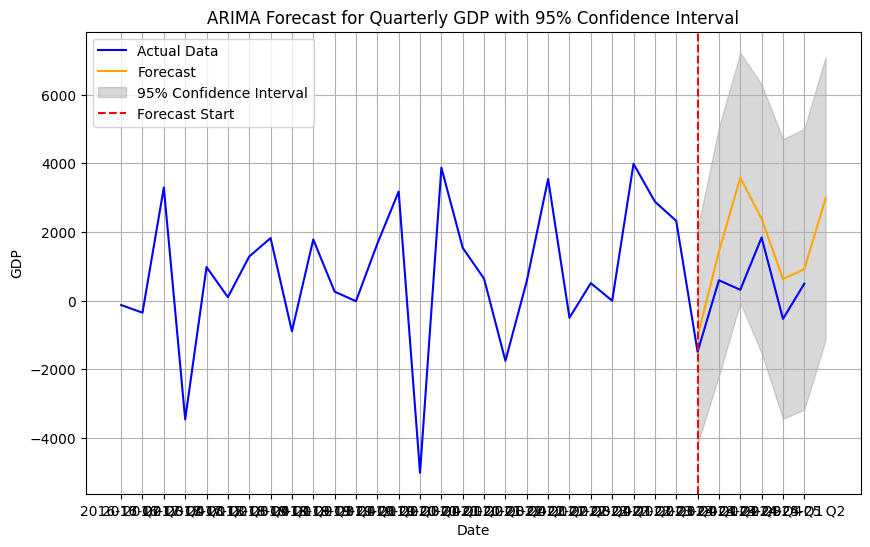

In [58]:
# Train ARIMA
arima_model = ARIMA(train, order=(4, 1, 3))  # Replace p, d, q with your parameters
arima_result = arima_model.fit()

# Forecast on Test Set
forecast = arima_result.get_forecast(steps=7, alpha=0.05)
forecast_values = forecast.predicted_mean  # Predicted values
conf_int = forecast.conf_int(alpha=0.05) 
print(mean_squared_error(test, forecast_values))
plt.figure(figsize=(10, 6))
plt.plot(sbi['QUARTERS'][1:], sbi_diff['NII'], label='Actual Data', color='blue')
plt.plot(test.index, forecast_values, label='Forecast', color='orange')
plt.fill_between(
    test.index, 
    conf_int.iloc[:, 0],  # Lower bound of the confidence interval
    conf_int.iloc[:, 1],  # Upper bound of the confidence interval
    color='gray', 
    alpha=0.3, 
    label='95% Confidence Interval'
)
plt.axvline(test.index[0], color='red', linestyle='--', label='Forecast Start')
plt.title('ARIMA Forecast for Quarterly GDP with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid()
plt.show()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

AR Model Mean Squared Error: 5210040.724005429
ETS Model Mean Squared Error: 3152650.931051321


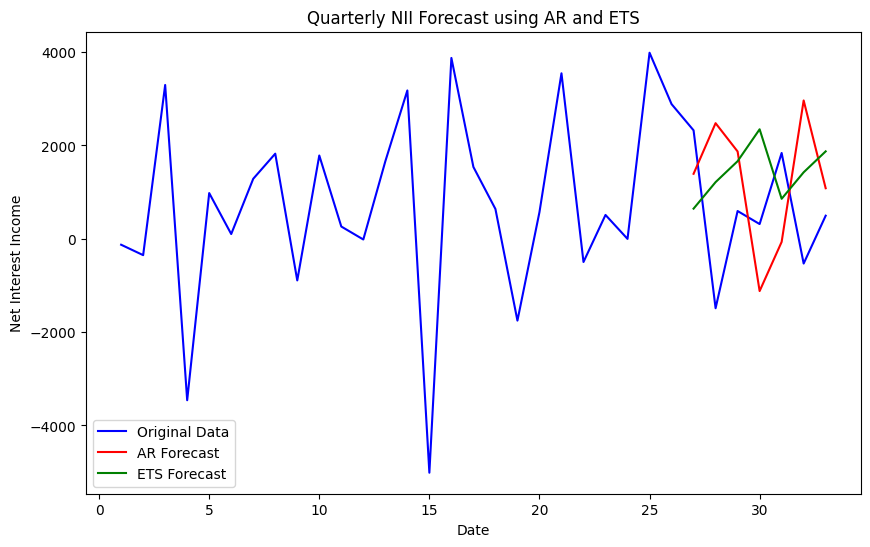

In [54]:
# 1. AR (AutoReg) Model
ar_model = AutoReg(train, lags=5)  # Adjust lags based on your data
ar_model_fit = ar_model.fit()
ar_predictions = ar_model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# 2. ETS (Exponential Smoothing) Model
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=4)
ets_model_fit = ets_model.fit()
ets_predictions = ets_model_fit.forecast(steps=7)

# Evaluate the model performance (Mean Squared Error)
ar_mse = mean_squared_error(test, ar_predictions)
ets_mse = mean_squared_error(test, ets_predictions)

print(f"AR Model Mean Squared Error: {ar_mse}")
print(f"ETS Model Mean Squared Error: {ets_mse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sbi_diff['NII'].index, sbi_diff['NII'], label='Original Data', color='blue')
plt.plot(test.index, ar_predictions, color='red', label='AR Forecast')
plt.plot(test.index, ets_predictions, color='green', label='ETS Forecast')
plt.title('Quarterly NII Forecast using AR and ETS')
plt.xlabel('Date')
plt.ylabel('Net Interest Income')
plt.legend()
plt.show()